In [1]:
%load_ext autoreload
%autoreload 2

# 0 : Importation des librairies

Pour ce projet, j'ai besoin d'importer :
- librairies classiques de manipulations de données (**_pandas, numpy, scipy, sklearn_**)
- fonctions du dossier **_functions_**
- librairies classiques d'affichage (**_seaborn, matplotlib_**)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append('/content/drive/MyDrive/Case_Study_Quant_Assistant')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler

from functions.features import *

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 0.bis : Importation des fichiers

Le dataset était au format `.pkl`, mais j'ai pris le soin de le convertir au format `.xlsx`au préalable.

Comme à chaque nouveau dataset sur lequel je travaille, je fais une petite analyse du dataset, une prise en main qui me permet de connaître les particularités de mes données.

Commençons, par la forme :

In [3]:
df = pd.read_excel('/content/drive/MyDrive/Case_Study_Quant_Assistant/data/dataset_studycase.xlsx')
df.set_index('Unnamed: 0', inplace=True)
print("Les dimensions du dataset sont :", df.shape)

print(df.dtypes)
missing_values_summary(df, name = "df")

Les dimensions du dataset sont : (87934, 17)
imb_price_pos      float64
imb_price_neg      float64
nuclear_real       float64
fossil_gas_real    float64
imb_volume         float64
afrr_down          float64
afrr_up            float64
mfrr_down          float64
mfrr_up            float64
load_real          float64
load_fcst            int64
solar_fcst           int64
wind_fcst            int64
solar_real         float64
wind_real          float64
ID_QH_Last         float64
ID_QH_VWAP         float64
dtype: object

Missing Value summary for df (Total rows : 87934)
       Variable  Missing Count  Missing Value (%)
   nuclear_real            158           0.179680
fossil_gas_real            158           0.179680
      load_real             22           0.025019
     imb_volume             19           0.021607
     solar_real             11           0.012509
      wind_real             11           0.012509
        afrr_up              1           0.001137
      mfrr_down              1 

# 1.a : Gestion des valeurs manquantes

Étant donné la très faible proportion de valeurs manquantes, je vais simplement appliquer une interpolation temporelle à chaque colonne.

In [4]:
df = interpolate_time(df)
missing_values_summary(df, name = "df")


Missing Value summary for df (Total rows : 87934)
       Variable  Missing Count  Missing Value (%)
  imb_price_pos              0                0.0
  imb_price_neg              0                0.0
   nuclear_real              0                0.0
fossil_gas_real              0                0.0
     imb_volume              0                0.0
      afrr_down              0                0.0
        afrr_up              0                0.0
      mfrr_down              0                0.0
        mfrr_up              0                0.0
      load_real              0                0.0
      load_fcst              0                0.0
     solar_fcst              0                0.0
      wind_fcst              0                0.0
     solar_real              0                0.0
      wind_real              0                0.0
     ID_QH_Last              0                0.0
     ID_QH_VWAP              0                0.0


# 1.b : Gestion des valeurs aberrantes

J'ai choisi de ne pas effectuer de traitement spécifique des valeurs aberrantes. Dans un contexte lié au marché de l'énergie, ces valeurs extrêmes peuvent refléter des conditions exceptionnelles mais réelles, comme des déséquilibres soudains du réseau ou des pics de prix dus à des événements imprévus. Étant donné le volume suffisant de données (environ 85 000 lignes) et l'absence de signes évidents d'erreurs de mesure, je préfère laisser le modèle apprendre directement à partir de ces dynamiques, sans filtrage arbitraire qui risquerait de masquer des comportements pertinents.

# 1.c : Feature Engineering

Pour construire un modèle capable de prédire efficacement les volumes optimaux à acheter ou vendre (`target_volume`), j'ai enrichi les données brutes avec des variables dérivées qui traduisent à la fois la structure du marché de l'électricité et l'état physique du système.

J'ai d'abord intégré des erreurs de prévision comme `load_err`, `solar_err` et `wind_err`, car les écarts entre les prévisions et les valeurs réelles sont souvent révélateurs de déséquilibres imminents sur le réseau. Ensuite, j'ai calculé des agrégats énergétiques comme `total_prod` (production totale), `total_reserves` (somme des réserves aFRR et mFRR), et `total_diff` (différence entre production et consommation) pour quantifier l'équilibre global du système.

Sur le plan financier, j'ai introduit `spread_long` et `spread_short`, qui mesurent l'écart entre les prix du marché intraday et les prix d'ajustement. Ces spreads me permettent d'identifier les situations favorables à l'achat ou à la vente. À partir d'eux, j'ai défini une variable `position` indiquant la stratégie optimale (achat, vente ou neutre), que j'ai traduite ensuite en `target_volume`, c'est-à-dire un volume d'action standardisé. Pour évaluer ce que cette position aurait pu rapporter, j'ai également calculé un PnL théorique (`PnL_optimal`).

Comme la capacité réelle du système à absorber un déséquilibre est déterminante, j'ai ajouté deux ratios de couverture (`afrr_cover_ratio`, `mfrr_cover_ratio`) ainsi qu'un indicateur logique (`imbalance_status`) qui décrit si le déséquilibre est couvert ou non. J'ai aussi construit une variable `historical_spread`, qui donne un signal directionnel basé sur les opportunités de spread historiquement observées.

Enfin, j'ai aussi tenu compte de la saisonnalité à travers des variables temporelles comme `hour`, `dayofweek`, `month`, etc., et j'ai introduit des **versions décalées** dans le temps de certaines variables (par exemple `load_real_lagged_4`, `spread_long_lagged_5`, etc.) pour capturer l'inertie des signaux et les dynamiques passées.

Le choix des lags 4, 5 et 6 n'est pas arbitraire : dans les marchés de l'électricité, les données dites “réelles” (comme les productions effectives ou les volumes déséquilibrés) ne sont généralement **accessibles qu'environ une heure après la clôture**. En pratique, cela signifie que lorsqu'on prend une décision à un instant donné, on ne dispose que des valeurs confirmées des heures précédentes. L'idée est donc de reproduire fidèlement l'information réellement disponible au moment de la décision, en utilisant les valeurs observées à H-1, H-2, H-3.

L'implémentation de toutes ces transformations est centralisée dans le fichier `functions.py`.

In [5]:
# Erreurs de prévision
df["load_err"] = df["load_fcst"] - df["load_real"]
df["solar_err"] = df["solar_fcst"] - df["solar_real"]
df["wind_err"] = df["wind_fcst"] - df["wind_real"]

# Agrégats énergétiques
df["total_prod"] = df["nuclear_real"] + df["fossil_gas_real"] + df["solar_real"] + df["wind_real"]
df["total_reserves"] = df["afrr_up"] + df["afrr_down"] + df["mfrr_up"] + df["mfrr_down"]
df["total_diff"] = df["total_prod"] - df["load_real"]

# Spreads et position optimale
df["spread_long"] = df["imb_price_pos"] - df["ID_QH_VWAP"]
df["spread_short"] = df["ID_QH_VWAP"] - df["imb_price_neg"]
df["position"] = df.apply(classify_spread, axis=1)
df["target_volume"] = df.apply(map_position_to_volume, axis=1)
df["PnL_optimal"] = df.apply(compute_PnL_optimal, axis=1)

# Historique exploitable
df["historical_spread"] = df.apply(lambda row: compute_historical_spread(row, df), axis=1)

# Statut du déséquilibre
df["imbalance_status"] = df.apply(coverage_status, axis=1)

# Ratios de couverture
df = compute_coverage_ratios(df)

# Variables temporelles
df = add_temporal_features(df)

# Variables laggées
lag_dict = {
    "imb_price_pos": [4, 5, 6],
    "imb_price_neg": [4, 5, 6],
    "nuclear_real": [4, 5, 6],
    "solar_fcst": [4, 5, 6],
    "wind_fcst": [4, 5, 6],
    "fossil_gas_real": [4, 5, 6],
    "imb_volume": [4, 5, 6],
    "load_real": [4, 5, 6],
    "load_err": [4, 5, 6],
    "solar_real": [4, 5, 6],
    "solar_err": [4, 5, 6],
    "wind_real": [4, 5, 6],
    "wind_err": [4, 5, 6],
    "afrr_up": [4, 5, 6],
    "afrr_down": [4, 5, 6],
    "mfrr_up": [4, 5, 6],
    "mfrr_down": [4, 5, 6],
    "historical_spread": [4, 5, 6],
    "afrr_cover_ratio": [4, 5, 6],
    "mfrr_cover_ratio": [4, 5, 6],
    "imbalance_status": [4, 5, 6],
    "spread_long": [4, 5, 6],
    "spread_short": [4, 5, 6],
    "total_reserves": [4, 5, 6],
    "total_diff": [4, 5, 6],
    "total_prod": [4, 5, 6],
    "target_volume": [4, 5, 6]
}

df = lag_features(df, lag_dict)
df = df.ffill()

/content/drive/MyDrive/Case_Study_Quant_Assistant/functions/features.py:128: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lagged_col] = df[name].shift(lag)
/content/drive/MyDrive/Case_Study_Quant_Assistant/functions/features.py:128: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lagged_col] = df[name].shift(lag)
/content/drive/MyDrive/Case_Study_Quant_Assistant/functions/features.py:128: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perf

# 1.d : Analyse des corrélations

Avant d'entraîner un modèle, je vais examiner la matrice de corrélation entre les variables explicatives.

Comme la matrice de corrélation complète contient 121 variables, elle devient rapidement illisible et difficile à interpréter. Plutôt que de tenter une analyse exhaustive et confuse, j'ai choisi de me concentrer uniquement sur les 20 variables les plus corrélées à ma variable cible `target_volume`. Cela permet de simplifier la visualisation et de mieux comprendre les relations linéaires significatives entre les variables explicatives les plus pertinentes. Une fois ces variables identifiées, j'en extrais leur matrice de corrélation partielle pour en observer les interactions.

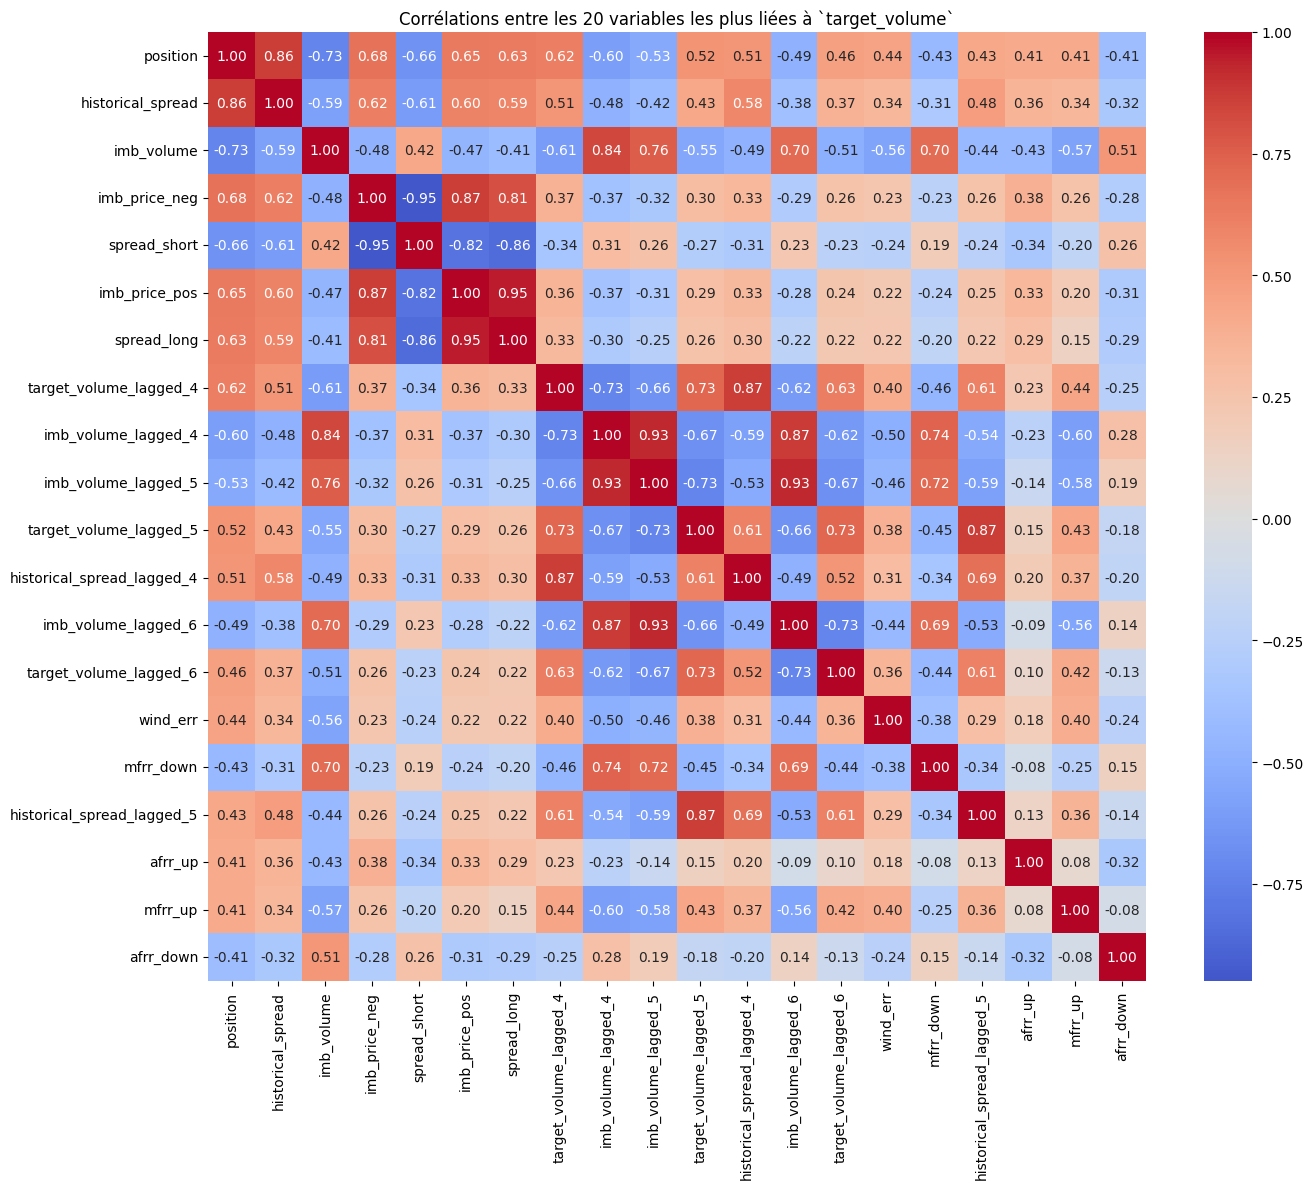

In [6]:
target_corr = df.corr()["target_volume"].drop("target_volume").sort_values(key = lambda x: abs(x), ascending=False)

# Sélection des 20 variables les plus corrélées avec la target
top_vars = target_corr.head(20).index.tolist()
top_corr_matrix = df[top_vars].corr()

plt.figure(figsize=(14, 12))
sns.heatmap(top_corr_matrix, cmap="coolwarm", center=0, annot=True, fmt=".2f")
plt.title("Corrélations entre les 20 variables les plus liées à `target_volume`")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

D'après cette matrice de corrélation restreinte aux variables les plus liées à la cible `target_volume`, plusieurs éléments ressortent clairement.

Tout d'abord, la variable `position`, qui représente la direction du spread, est fortement corrélée à `target_volume`, ce qui est attendu puisque position guide la logique d'achat ou de vente.

Les variables `historical_spread`, `spread_long`, `spread_short`, ainsi que `imb_price_pos` et `imb_price_neg` présentent également des corrélations élevées, confirmant leur rôle central dans la dynamique des prix d'équilibre.

On observe aussi que certaines variables laggées, comme `target_volume_lagged_4`, `imb_volume_lagged_4`, `historical_spread_lagged_4` ou `target_volume_lagged_5`, conservent une corrélation notable avec la target, ce qui justifie l'intérêt d'inclure une mémoire temporelle dans le modèle.

Enfin, des variables comme `wind_err`, `mfrr_down` ou `afrr_up` présentent des corrélations plus modestes mais potentiellement utiles pour capturer des effets secondaires du système électrique. Cette analyse met donc en évidence à la fois les composantes directement liées aux spreads et celles qui capturent la structure du déséquilibre du réseau.

# 2 : Mise en place du modèle




Fold 1
Epoch 1 - Train Loss: 51.2098 | Val Loss: 52.5341
Epoch 2 - Train Loss: 43.8982 | Val Loss: 51.6933
Epoch 3 - Train Loss: 42.6919 | Val Loss: 51.3076
Epoch 4 - Train Loss: 41.7188 | Val Loss: 51.0072
Epoch 5 - Train Loss: 40.9820 | Val Loss: 50.9965
Epoch 6 - Train Loss: 40.3466 | Val Loss: 51.2313
Epoch 7 - Train Loss: 39.7208 | Val Loss: 51.4635
Epoch 8 - Train Loss: 39.0822 | Val Loss: 52.1214
Epoch 9 - Train Loss: 38.5323 | Val Loss: 52.7545
Epoch 10 - Train Loss: 37.9252 | Val Loss: 54.0748
Epoch 11 - Train Loss: 37.4122 | Val Loss: 55.1816
Epoch 12 - Train Loss: 36.8341 | Val Loss: 56.6395
Epoch 13 - Train Loss: 36.2750 | Val Loss: 58.4209
Epoch 14 - Train Loss: 35.7213 | Val Loss: 60.6918
Epoch 15 - Train Loss: 35.1258 | Val Loss: 62.0386
Epoch 16 - Train Loss: 34.5650 | Val Loss: 63.2441
Epoch 17 - Train Loss: 34.0478 | Val Loss: 65.0506
Epoch 18 - Train Loss: 33.4133 | Val Loss: 65.9225
Epoch 19 - Train Loss: 32.8297 | Val Loss: 68.4064
Epoch 20 - Train Loss: 32.2491 |

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


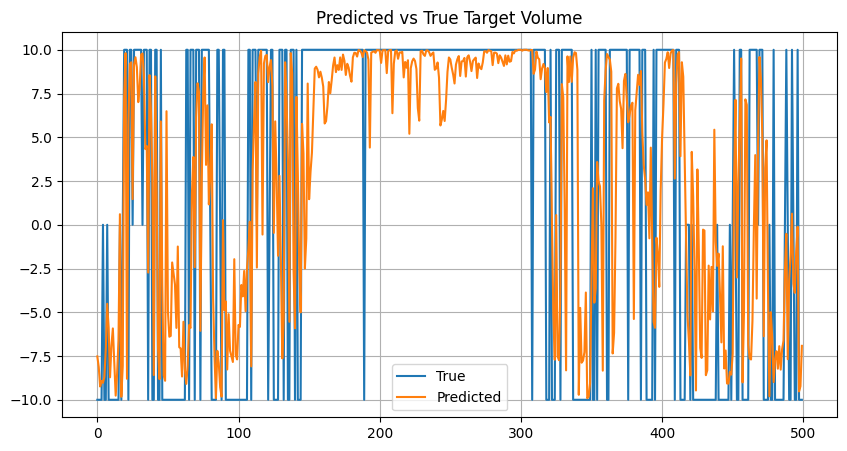

In [7]:
test_size = int(0.1 * len(df))
df_train = df[:-test_size]
df_test = df[-test_size:]

features = ['afrr_down_lagged_4',
 'imbalance_status_lagged_4',
 'spread_long_lagged_4',
 'imb_volume_lagged_5',
 'historical_spread_lagged_4',
 'target_volume_lagged_4',
 'imb_volume_lagged_4',
 'target_volume_lagged_5',
 'target_volume_lagged_6',
 'wind_err_lagged_4',
 'quarter',
 'afrr_cover_ratio_lagged_4',
 'total_prod_lagged_5',
 'hour',
 'load_fcst',
 'load_real_lagged_4',
 'mfrr_up_lagged_4',
 'month',
 'mfrr_down_lagged_4',
 'wind_err_lagged_5',
 'afrr_up_lagged_6',
 'solar_real_lagged_6',
 'solar_real_lagged_5',
 'total_reserves_lagged_6',
 'ID_QH_Last',
 'imb_price_neg_lagged_4',
 'year',
 'spread_long_lagged_5',
 'imbalance_status_lagged_5',
 'afrr_cover_ratio_lagged_6',
 'ID_QH_VWAP',
 'solar_err_lagged_5',
 'solar_err_lagged_4',
 'solar_fcst',
 'wind_fcst',
 'wind_real_lagged_4',
 'wind_real_lagged_5',
 'load_err_lagged_4',
 'total_diff_lagged_6',
 'load_err_lagged_6',
 'dayofweek',
 'fossil_gas_real_lagged_4',
 'fossil_gas_real_lagged_6',
 'afrr_cover_ratio_lagged_5']

X = df_train[features].values
y = df_train['target_volume'].values.reshape(-1, 1)

# Standardisation
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# === Configuration ===
epochs = 20
batch_size = 64
learning_rate = 0.001

# === Suivi global ===
models = []
predictions_per_fold = []
losses_per_fold = []

# === TimeSeriesSplit ===
tscv = TimeSeriesSplit(n_splits=5)
for fold, (train_idx, val_idx) in enumerate(tscv.split(X_scaled)):
    print(f"\nFold {fold+1}")
    X_train, X_val = X_scaled[train_idx], X_scaled[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    # === Tensors ===
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

    train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=False)
    val_loader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=batch_size)

    # === Modèle ===
    model = nn.Sequential(
        nn.Linear(X.shape[1], 128),
        nn.ReLU(),
        nn.Linear(128, 32),
        nn.ReLU(),
        nn.Linear(32, 1),
        nn.Tanh()
    )

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    loss_fn = nn.MSELoss()

    train_losses = []
    val_losses = []

    # === Entraînement ===
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            output = 10 * model(X_batch)
            loss = loss_fn(output, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        train_loss = total_loss / len(train_loader)

        # === Validation ===
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                preds = 10 * model(X_batch)
                val_loss += loss_fn(preds, y_batch).item()
        val_loss /= len(val_loader)

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        print(f"Epoch {epoch+1} - Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    # Sauvegarde du modèle et des prédictions fold
    models.append(model)
    losses_per_fold.append((train_losses, val_losses))

    # Prédictions validation
    with torch.no_grad():
        val_preds = (10 * model(X_val_tensor)).numpy().flatten()
        predictions_per_fold.append((val_preds, y_val.flatten()))

# === Visualisation finale ===
def plot_predictions(y_true, y_pred):
    plt.figure(figsize=(10, 5))
    plt.plot(y_true[:500], label='True')
    plt.plot(y_pred[:500], label='Predicted')
    plt.title("Predicted vs True Target Volume")
    plt.legend()
    plt.grid(True)
    plt.show()

# === Évaluation finale sur test set ===
X_test = scaler.transform(df_test[features])
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

best_model = models[-1]  # dernier modèle entraîné (apprentissage cumulatif)
best_model.eval()
with torch.no_grad():
    predictions_torch = (10 * model(X_test_tensor)).numpy().flatten()

plot_predictions(df_test['target_volume'].values, predictions_torch)

In [8]:
def adjust_prediction(vol, borne_sup=5, borne_inf=5):
    if vol >= borne_sup: return 10
    elif vol <= -borne_inf: return -10
    elif abs(vol) < 1: return 0
    return vol

# === Test the best adjustment thresholds naively ===
PL_list=[]
test_df = df_test.copy()

for borne_sup in range(0, 10, 1):
  for borne_inf in range(0, 10, 1):
    test_df['prediction'] = np.array([adjust_prediction(v, borne_sup, borne_inf) for v in predictions_torch])
    test_df["realized_PnL"] = test_df.apply(compute_realized_PnL, axis=1)
    PL_list.append((borne_sup, borne_inf, test_df["realized_PnL"].sum()))

PL_list.sort(key=lambda x: x[2])
PL_list


[(9, 9, np.float64(46035192.96981025)),
 (9, 8, np.float64(46738400.31005899)),
 (8, 9, np.float64(46841557.86101157)),
 (9, 7, np.float64(47366912.6952177)),
 (8, 8, np.float64(47544765.20126032)),
 (7, 9, np.float64(47966095.68165349)),
 (9, 6, np.float64(48041646.765862755)),
 (8, 7, np.float64(48173277.58641904)),
 (6, 9, np.float64(48583168.43795846)),
 (7, 8, np.float64(48669303.02190225)),
 (9, 5, np.float64(48842622.831921846)),
 (8, 6, np.float64(48848011.65706409)),
 (5, 9, np.float64(49051208.712798126)),
 (0, 9, np.float64(49202095.62097465)),
 (9, 4, np.float64(49269944.79270731)),
 (6, 8, np.float64(49286375.778207205)),
 (7, 7, np.float64(49297815.40706095)),
 (2, 9, np.float64(49422638.219323665)),
 (4, 9, np.float64(49489721.63582018)),
 (1, 9, np.float64(49522658.320974655)),
 (3, 9, np.float64(49609623.15765183)),
 (8, 5, np.float64(49648987.72312318)),
 (5, 8, np.float64(49754416.053046875)),
 (9, 3, np.float64(49755380.04019846)),
 (0, 8, np.float64(49905302.961223

In [9]:
best_sup, best_inf = 4, 0

test_df["prediction"] = np.array([adjust_prediction(v, best_sup, best_inf) for v in predictions_torch])
test_df["realized_PnL"] = test_df.apply(compute_realized_PnL, axis=1)

# Résultats
realized = test_df["realized_PnL"].sum()
optimal = test_df["PnL_optimal"].sum()
performance_pct = 100 * realized / optimal

print(f"PnL réalisé : {realized:,.2f}")
print(f"PnL optimal : {optimal:,.2f}")
print(f"Performance réalisée : {performance_pct:.2f}%")

PnL réalisé : 54,901,119.01
PnL optimal : 86,230,728.40
Performance réalisée : 63.67%


In [10]:
def analyze_model_decisions(df, pred_col='prediction', pos_col='position'):
    df = df.copy()

    def classify(row):
        pos = row[pos_col]
        pred = row[pred_col]
        if pos == 0 and pred != 0:
            return 'Mauvaise prise de position'
        elif pos != 0 and pred == 0:
            return 'Opportunité manquée'
        elif pos != 0 and np.sign(pos) == np.sign(pred):
            return 'Bonne prédiction'
        elif pos != 0 and np.sign(pos) != np.sign(pred):
            return 'Contre-sens'
        else:
            return 'Neutre'

    df["decision_case"] = df.apply(classify, axis=1)
    summary = df["decision_case"].value_counts()
    total = summary.sum()

    print("=== Analyse des décisions du modèle ===")
    for label in ["Bonne prédiction", "Opportunité manquée", "Mauvaise prise de position", "Contre-sens", "Neutre"]:
        count = summary.get(label, 0)
        print(f"{label:<30} : {count:5d}  ({count / total * 100:.2f}%)")

    return df

df_analyzed = analyze_model_decisions(test_df)

=== Analyse des décisions du modèle ===
Bonne prédiction               :  6359  (72.32%)
Opportunité manquée            :   276  (3.14%)
Mauvaise prise de position     :   303  (3.45%)
Contre-sens                    :  1847  (21.01%)
Neutre                         :     8  (0.09%)
